**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

2024-07-17 08:59:09.576941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 08:59:10.296754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [4]:
import glob, os, sys
sys.path.append('/workspace/stardist')
from utils.utils import *

train_dirs = {
    "train": "/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/6/MoNuSegTrainingData/",
}

test_dirs = {
    # "test": ["/mnt/dataset/MoNuSeg/patches_256x256_128x128/ResNet18_kmeans_10_v1.1/4/MoNuSegTestData"],
    # "val": ["/mnt/dataset/MoNuSeg/patches_valid_inst_256x256_128x128/MoNuSegTestData"],
    "test": ["/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/"],
}

train_file_list, train_label = get_file_label(train_dirs, gt=True)
test_file_list, test_label = get_file_label(test_dirs, gt=True)

print("train files -> ", len(train_file_list))
print("test files -> ", len(test_file_list))

syn_dirs = {
    "syn": ["/mnt/cvai_s3/CVAI/genai/Stardist_data/patches_valid_inst_128x128_128x128/05ss/"],
}

syn_file_list, _ = get_file_label(syn_dirs, img_path='images_in_silico_inst', inst_path='masks_in_silico_inst')

print("syn files -> ", len(syn_file_list))



train files ->  1406
test files ->  896
syn files ->  0


In [5]:
# sdm_pardir = "/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6"
sdm_pardir = "/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6"
sdm_dirs = sorted(glob.glob(os.path.join(sdm_pardir, "v1.1_*")))

sdm_dirs = [x for x in sdm_dirs if 'output_ema' not in x]

sdm_dirs = {os.path.split(k)[-1] : k for k in sdm_dirs}
print(sdm_dirs)

sdm_dirs.pop("output_shuffle_model_s1.5_040000", None)
sdm_dirs.pop("output_clus4_shuffle_model_s1.5_040000", None)
sdm_dirs.pop("v1.1_output_model_s1.2_030000", None)

sdm_file_list, sdm_label = get_file_label(sdm_dirs, img_path='samples', inst_path='inst_masks')

print("sdm_file_list -> ", len(sdm_file_list))




{'v1.1_output_model_s1.2_040000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.2_040000', 'v1.1_output_model_s1.2_050000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.2_050000', 'v1.1_output_model_s1.4_030000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.4_030000', 'v1.1_output_model_s1.4_040000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.4_040000', 'v1.1_output_model_s1.4_050000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.4_050000', 'v1.1_output_model_s1.5_030000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.5_030000', 'v1.1_output_model_s1.5_040000': '/mnt/dataset/MoNuSeg/out_sdm/patches_vali

In [6]:
## Read images

In [7]:
from tqdm.notebook import tqdm
from stardist import fill_label_holes

n_channel = 3
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

img_preprocess = lambda x : normalize(x,1,99.8,axis=axis_norm)
label_preprocess = lambda x : fill_label_holes(x)

x_id = 0
y_id = 2
mask_dtype = 'I'

img_train = list(map(lambda x: read_img(x[x_id], 'RGB'), tqdm(train_file_list)))
X_train = list(map(lambda x: img_preprocess(read_img(x[x_id], 'RGB')), tqdm(train_file_list)))
Y_train = list(map(lambda x: label_preprocess(read_img(x[y_id], mask_dtype)), tqdm(train_file_list)))

img_test = list(map(lambda x: read_img(x[x_id], 'RGB'), tqdm(test_file_list)))
X_test = list(map(lambda x: img_preprocess(read_img(x[x_id], 'RGB')), tqdm(test_file_list)))
Y_test = list(map(lambda x: label_preprocess(read_img(x[y_id], mask_dtype)), tqdm(test_file_list)))


X_syn = list(map(lambda x: img_preprocess(read_img(x[x_id], 'RGB')), tqdm(syn_file_list)))
Y_syn = list(map(lambda x: label_preprocess(read_img(x[y_id], mask_dtype)), tqdm(syn_file_list)))

img_sdm = list(map(lambda x: read_img(x[x_id], 'RGB'), tqdm(sdm_file_list)))
X_sdm = list(map(lambda x: img_preprocess(read_img(x[x_id], 'RGB')), tqdm(sdm_file_list)))
Y_sdm = list(map(lambda x: label_preprocess(read_img(x[y_id], mask_dtype)), tqdm(sdm_file_list)))


Normalizing image channels independently.


  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

In [8]:
## FID Scores

In [4]:
from collections import defaultdict
import pandas as pd

fid_arr = []

for k, v in sdm_dirs.items():
    with open(os.path.join(v, 'FID.txt')) as f:
        line = f.readlines()[-1]
        fid = float(line.strip().split()[-1])
        fid_arr.append(fid)


fid = dict(
    fid = fid_arr,
    exp = [x[:-12] for x in sdm_dirs.keys()],
    iter = [x[-6:] for x in sdm_dirs.keys()],
    s_val = [x[-11:-7] for x in sdm_dirs.keys()],
)

fid = pd.DataFrame.from_dict(fid)



In [1]:
# MedSAM feat

In [1]:
# Install from https://github.com/facebookresearch/segment-anything
from segment_anything import SamPredictor, sam_model_registry
from tqdm.notebook import tqdm
import torch

from PIL import Image
import blobfile as bf

def get_medsam_feat(images, model_weights_path="/mnt/dataset/medsam/medsam_vit_b.pth"):

    model_type = "vit_b"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    sam = sam_model_registry[model_type](checkpoint=model_weights_path).to(device)
    predictor = SamPredictor(sam)

    feats = []

    def load_img(path):

        with bf.BlobFile(path, "rb") as f:
            pil_image = Image.open(f)
            pil_image.load()
        pil_image = pil_image.convert("RGB")

        return np.array(pil_image)

    for img in tqdm(images):

        if isinstance(img, np.ndarray):
            pass
        elif isinstance(img, 'str'):
            img = load_img(img)
        else:
            raise NotImplementedError

        # Find a way to increase batch size
        predictor.set_image(img)

        # *** This is how you can access the patch embeddings ***
        patch_embeddings = predictor.features
        # patch_embeddings.shape gives: torch.Size([1, 256, 64, 64])

        # use maxpool?
        feat = patch_embeddings.mean(axis=1).flatten().cpu().detach().numpy()

        feats.append(feat)

    return np.array(feats)


from pytorch_fid.fid_score import calculate_frechet_distance


def get_frechet_dist(act1, act2):
    """
    
    """

    m1 = np.mean(act1, axis=0)
    s1 = np.cov(act1, rowvar=False)

    m2 = np.mean(act2, axis=0)
    s2 = np.cov(act2, rowvar=False)

    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value



In [9]:
feat_medsam_train = get_medsam_feat(img_train)
feat_medsam_test = get_medsam_feat(img_test)

fSAMd = get_frechet_dist(feat_medsam_train, feat_medsam_test)

print(fSAMd)


  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

0.008848515216970356


In [10]:
feat_medsam_sdm = get_medsam_feat(img_sdm)


  0%|          | 0/1144 [00:00<?, ?it/s]

umap_.py (1945): n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


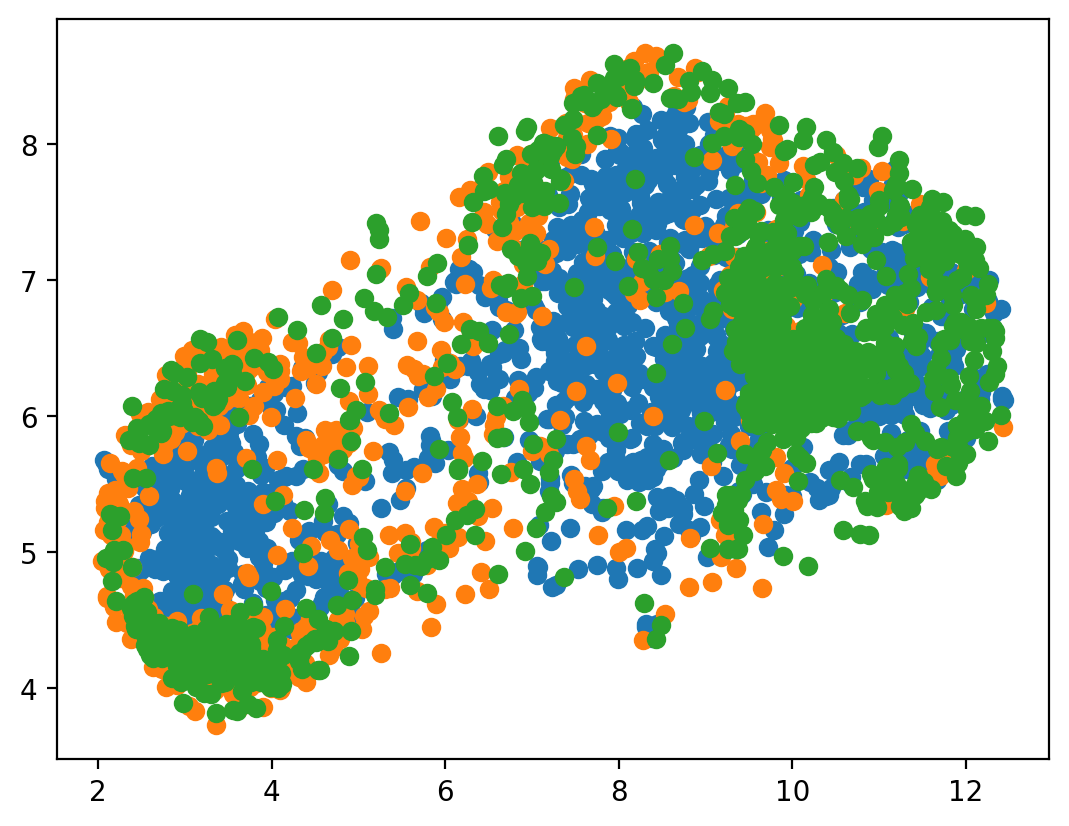

In [17]:
feat_train, feat_test, feat_sdm = get_umap_feat(feat_medsam_train, feat_medsam_test, feat_medsam_sdm)


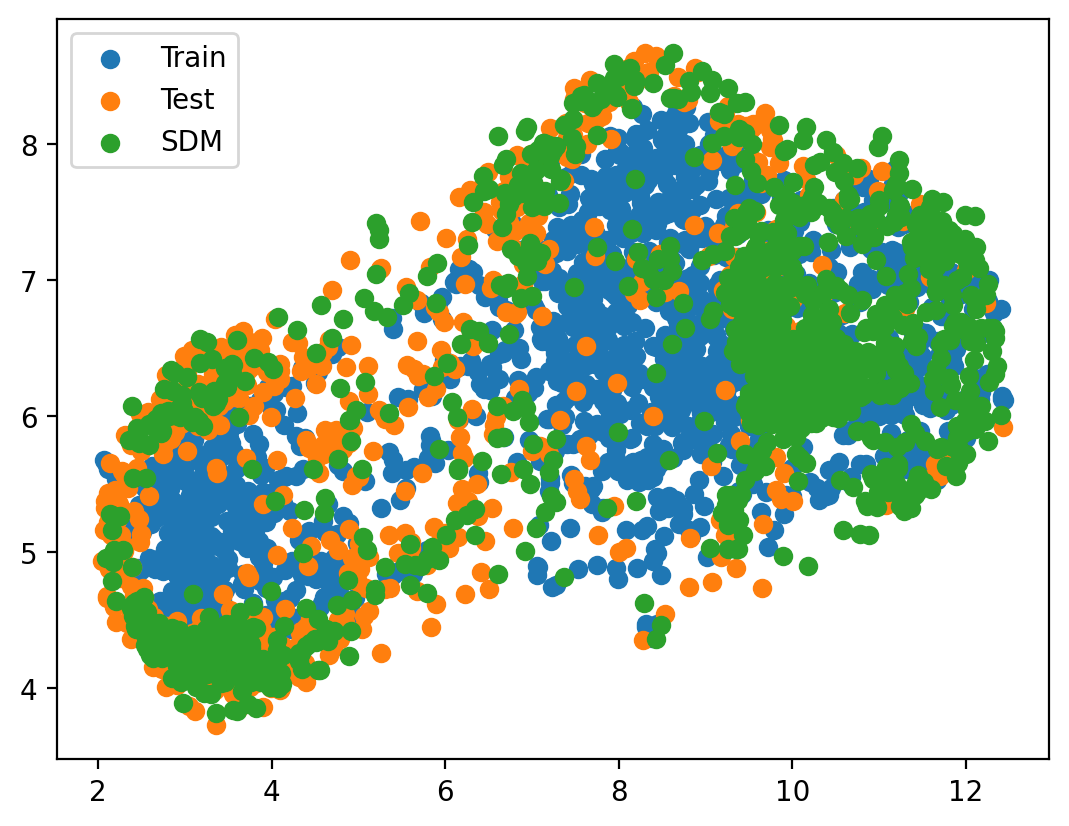

In [18]:
plt.figure()
plt.scatter(feat_train[:, 0], feat_train[:,1], label="Train")
plt.scatter(feat_test[:,0], feat_test[:,1], label="Test")
plt.scatter(feat_sdm[:,0], feat_sdm[:,1], label="SDM")
plt.legend()
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:

from hover_net.misc.embeddings import write_embedding, overwrite_embedding_classes

LOG_DIR = "tmp/sdm"
write_embedding(LOG_DIR, 
                img_train + img_test + img_sdm,
                list(feat_medsam_train) + list(feat_medsam_test) + list(feat_medsam_sdm),
                train_label + test_label + sdm_label)


writing labels...
writing embeddings...


100%|██████████| 3446/3446 [00:08<00:00, 421.45it/s]


writing images...


TypeError: cannot unpack non-iterable int object

In [11]:
uniq_labels = np.unique(sdm_label)
fSAMd_arr = []

for u in uniq_labels:
    ind = np.where(np.array(sdm_label) == u)
    print(ind)
    fSAMd = get_frechet_dist(feat_medsam_train, feat_medsam_sdm[ind])
    fSAMd_arr.append(fSAMd)

fSAMd_dic = dict(
    fSAMd = fSAMd_arr,
    exp = [x[:-12] for x in sdm_label],
    iter = [x[-6:] for x in sdm_label],
    s_val = [x[-11:-7] for x in sdm_label],
)

fSAMd = pd.DataFrame.from_dict(fSAMd)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103]),)
(array([104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [31]:
print(fSAMd)
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
plot_fid_sample(fSAMd, None, ax=ax, y='fSAMd', x='iter', hue='s_val', title=None)



(128, 128, 3)

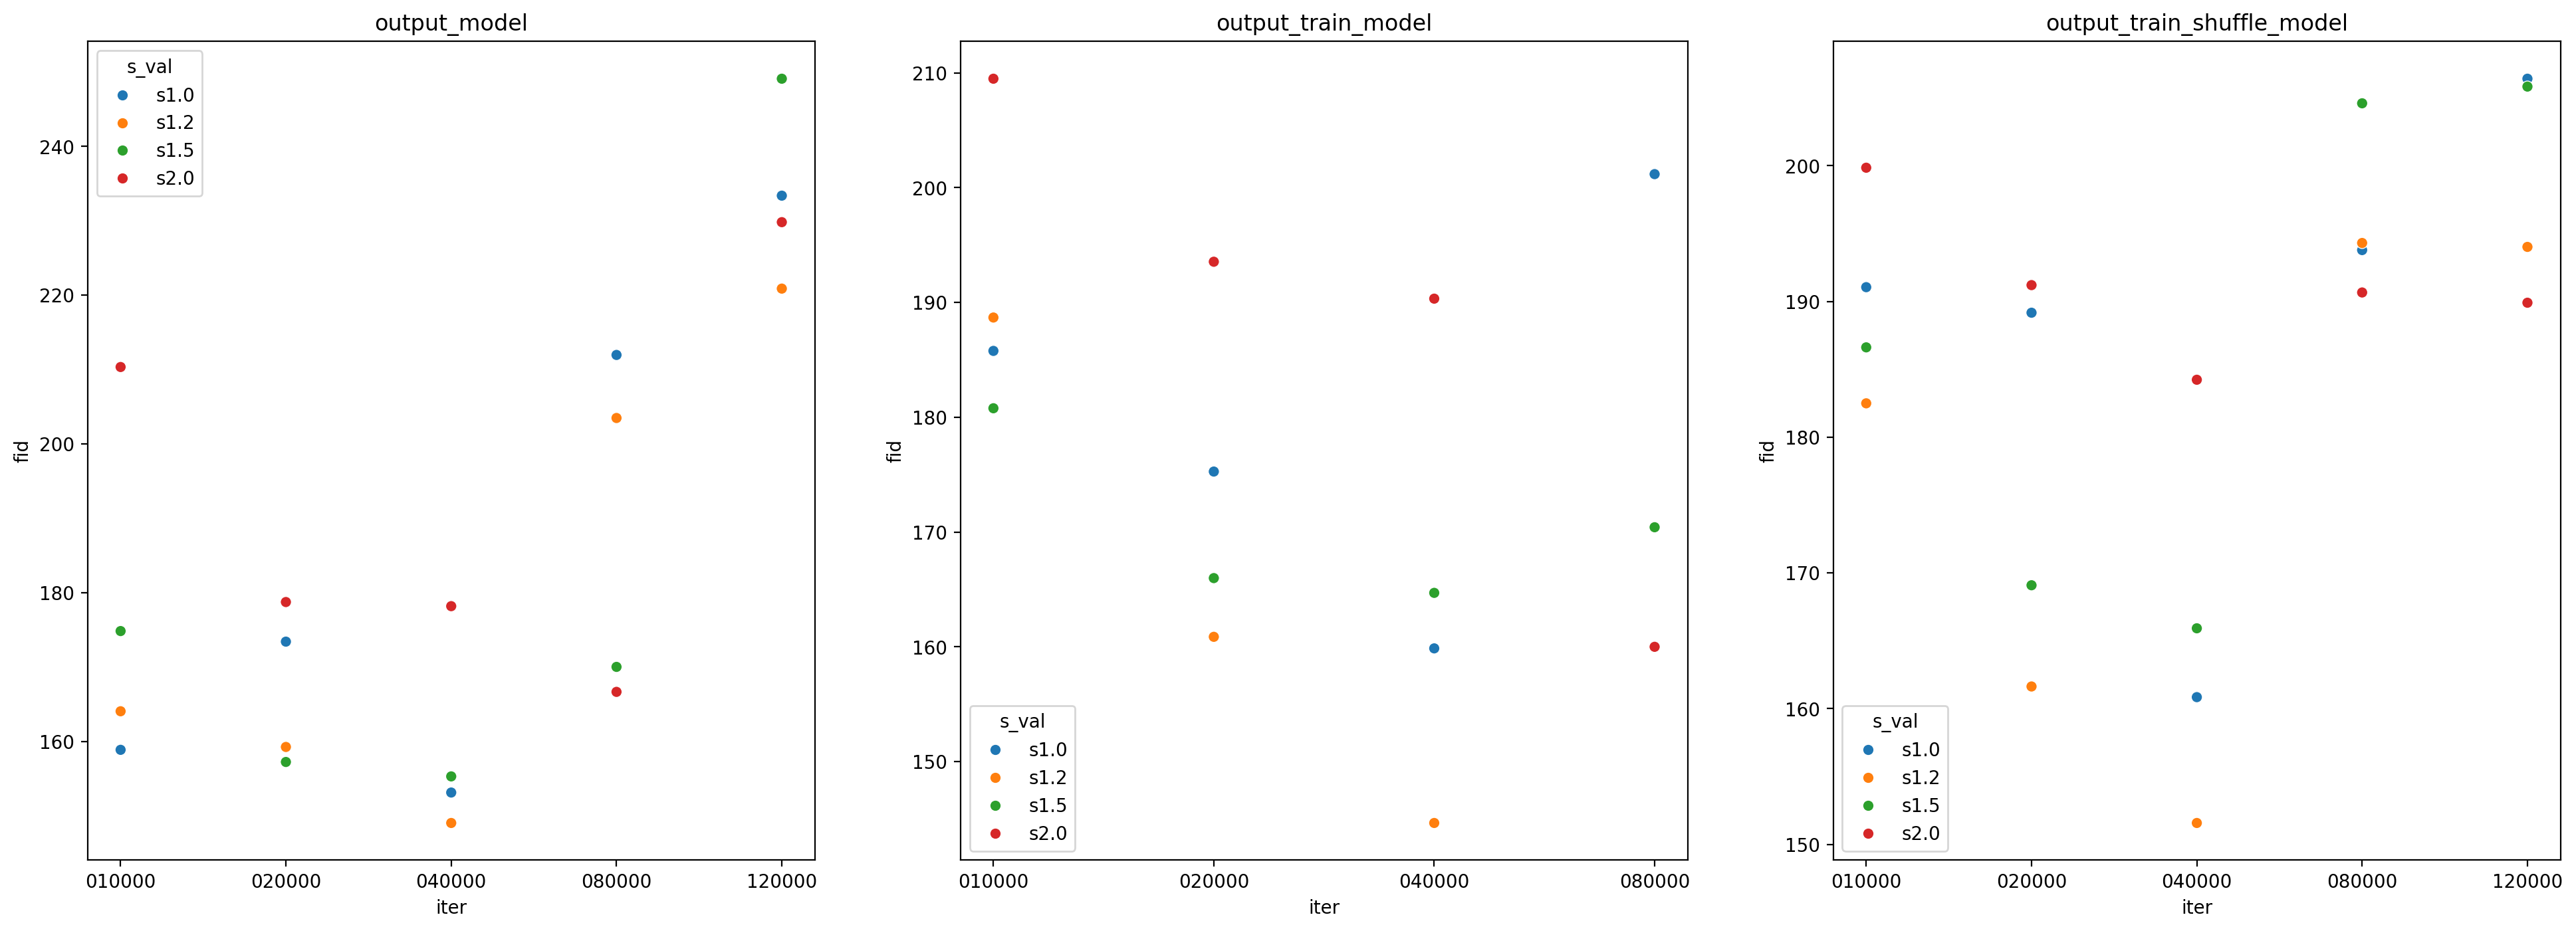

In [5]:
import seaborn as sns

def plot_fid_sample(fid, x_vals, y="fid", ax=None, **kwargs):
    if ax is None:
        plt.figure(figsize=(16, 8))
        ax = plt.gca()

    if 'title' in kwargs:
        title = kwargs.pop('title')

    if 'mean' in fid.keys():
        f1_mean = fid.pop('mean')
        plt.plot(x_vals, f1_mean, zorder=1, c='r', marker='x', label="mean")
    
    sns.scatterplot(data=fid, y="fid", x=kwargs['x'], hue=kwargs['hue'], ax=ax)
    # plt.title('F1 scores - Stardist trained on 128x128 images')
    ax.set_title(title)

    # plt.xticks(rotation=30)
    # plt.xticks(x_vals, [f'x{i}' for i in x_vals])

    for l in ax.lines:
        # print(l.get_data())
        if len(l.get_data()[1]) != 1 : continue
        ax.text(l.get_data()[0][0], l.get_data()[1][0], f'{l.get_data()[1][0]:.2f}',size='large')    



In [ ]:
exps = fid['exp'].unique()


fig, ax = plt.subplots(1, 3, figsize=(24, 8))
for i, exp in enumerate(exps):
    plot_fid_sample(fid[fid['exp'] == exp], None, ax=ax[i], x='iter', hue='s_val', title=exp)



# x_vals = np.unique(f1['exp'])
# plot_f1_sample(f1, x_vals)

In [ ]:
from scipy.stats import multivariate_normal


feat_train, feat_test, feat_sdm = get_umap_feat(feat_medsam_train, feat_medsam_test, feat_medsam_sdm, n_components=5)

rv = multivariate_normal(np.mean(feat_train, axis=0), np.cov(feat_train, rowvar=False))
prob = rv.pdf(feat_sdm)
prob.max()

Normalizing image channels independently.


  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1760 [00:00<?, ?it/s]

  0%|          | 0/1760 [00:00<?, ?it/s]

In [ ]:

prob_dic = dict(
    prob_medSAM = prob,
    exp = [x[:-12] for x in sdm_label],
    iter = [x[-6:] for x in sdm_label],
    s_val = [x[-11:-7] for x in sdm_label],
)


In [ ]:
import seaborn as sns

def plot_val_sample(f1, x_vals, y="F1", ax=None, **kwargs):
    if ax is None:
        plt.figure(figsize=(16, 8))
        ax = plt.gca()

    if 'mean' in f1.keys():
        f1_mean = f1.pop('mean')
        plt.plot(x_vals, f1_mean, zorder=1, c='r', marker='x', label="mean")

    ax.set_title(kwargs.pop('title'))
    sns.violinplot(data=f1, y=y, x=kwargs['x'], hue=kwargs['hue'], ax=ax)

    # plt.title('F1 scores - Stardist trained on 128x128 images')
    # plt.xticks(rotation=30)
    # plt.xticks(x_vals, [f'x{i}' for i in x_vals])

    for l in ax.lines:
        # print(l.get_data())
        if len(l.get_data()[1]) != 1 : continue
        ax.text(l.get_data()[0][0], l.get_data()[1][0], f'{l.get_data()[1][0]:.2e}',size='large')    


In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
plot_f1_sample(prob_dic, None, ax=ax, y='prob_medSAM', x='iter', hue='s_val', title=None)


In [7]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [8]:
use_gpu = True

allocated_mem = min(6000, 10000)
print("Allocated memory:", allocated_mem)

if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8, total_memory=allocated_mem, allow_growth=False)


Allocated memory: 6000


In [9]:
demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model_stardist = StarDist2D.from_pretrained('2D_versatile_he')
else:
    # basedir='/mnt/dataset/stardist/models_monuseg_v1.3_Syn2GT'
    basedir='/mnt/dataset/stardist/models_monuseg_v1.3_Syn2GT'
    model_stardist = StarDist2D(None, name='stardist_128_128_05gt_inst/', basedir=basedir)
None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [10]:
ind = 20
img = X_sdm[ind]
ann = Y_sdm[ind]
labels, details = model_stardist.predict_instances(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(-0.5, 127.5, 127.5, -0.5),
 (-0.5, 127.5, 127.5, -0.5),
 (-0.5, 127.5, 127.5, -0.5)]

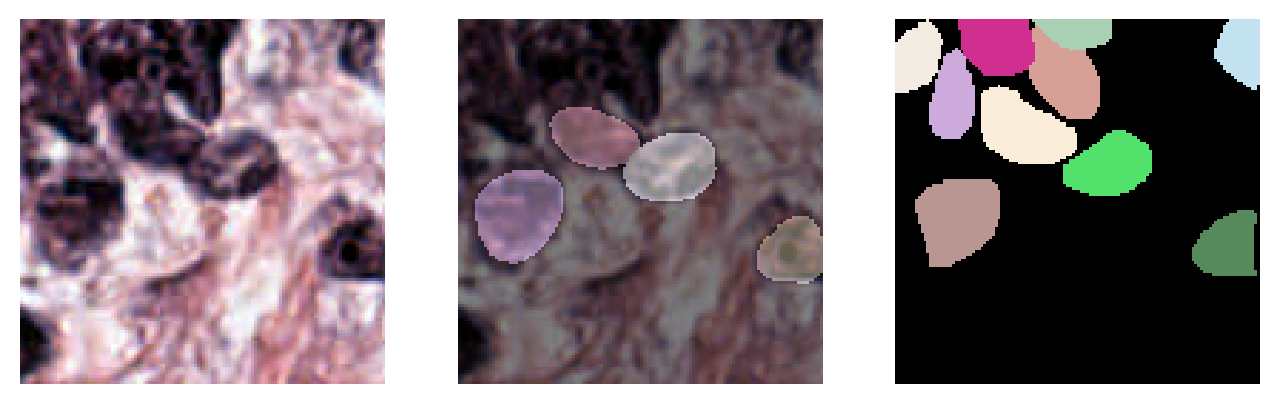

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(8,16))
ax[0].imshow(img, clim=(0,1))
ax[1].imshow(img, clim=(0,1))
ax[1].imshow(labels, cmap=lbl_cmap, alpha=0.5)
ax[2].imshow(ann, cmap=lbl_cmap)
[axis.axis('off') for axis in ax]

In [10]:
from stardist.matching import matching, matching_dataset

'''
Y_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
            for x in tqdm(X_test)]

# taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# stats = [matching_dataset(Y_test, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats_test = [matching(y_t, y_p, thresh=0.5, criterion='iou', report_matches=False) for y_t,y_p in zip(Y_test, Y_pred)]


Y_pred_syn = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
            for x in tqdm(X_syn)]

stats_syn = [matching(y_t, y_p, thresh=0.5, criterion='iou', report_matches=False) for y_t,y_p in zip(Y_syn, Y_pred_syn)]
'''

Y_pred_sdm = [model_stardist.predict_instances(x, n_tiles=model_stardist._guess_n_tiles(x), show_tile_progress=False)[0]
            for x in tqdm(X_sdm)]

stats_sdm = [matching(y_t, y_p, thresh=0.5, criterion='iou', report_matches=False) for y_t,y_p in zip(Y_sdm, Y_pred_sdm)]


  0%|          | 0/1760 [00:00<?, ?it/s]

In [11]:

# stats_sdm

In [12]:
stats_sdm = [s._asdict() for s in stats_sdm]
# stats_sdm

f1 = dict(
    F1 = [s['f1'] for s in stats_sdm],
    exp = [x[:-12] for x in sdm_label],
    iter = [x[-6:] for x in sdm_label],
    s_val = [x[-11:-7] for x in sdm_label],
)

f1 = pd.DataFrame.from_dict(f1)


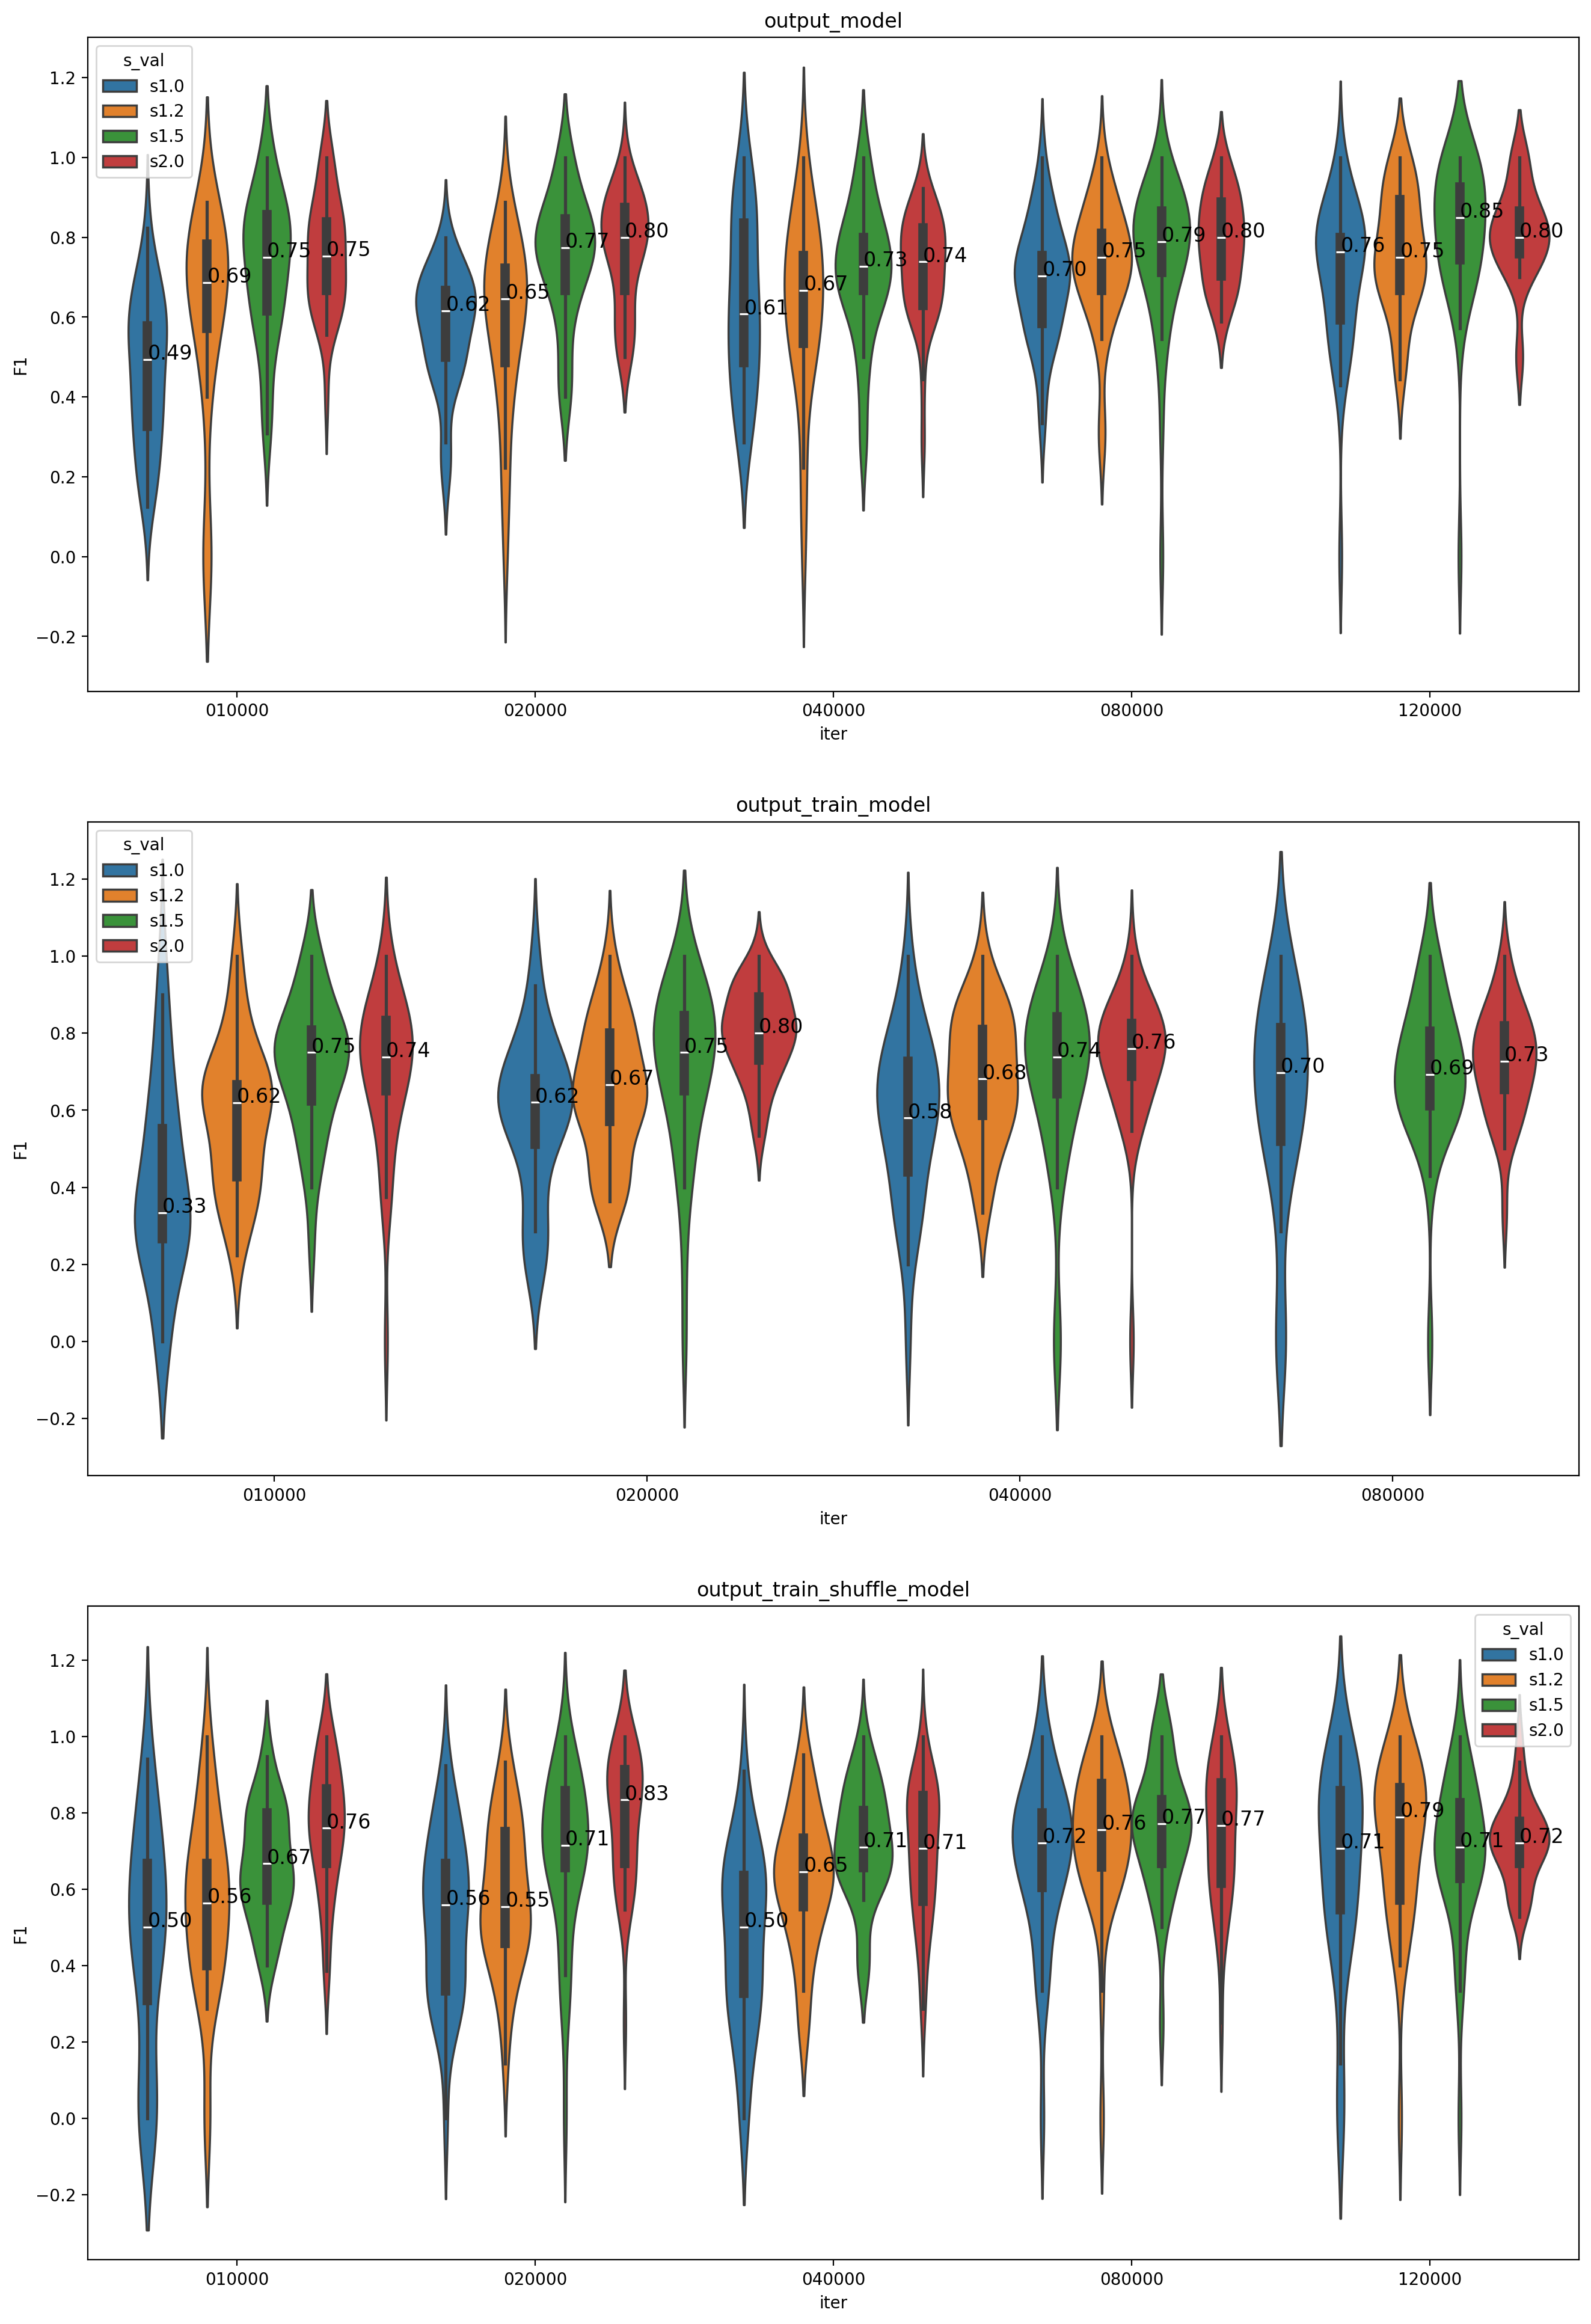

In [13]:
import seaborn as sns

def plot_f1_sample(f1, x_vals, ax=None, **kwargs):
    if ax is None:
        plt.figure(figsize=(16, 8))
        ax = plt.gca()

    if 'mean' in f1.keys():
        f1_mean = f1.pop('mean')
        plt.plot(x_vals, f1_mean, zorder=1, c='r', marker='x', label="mean")

    ax.set_title(kwargs.pop('title'))
    sns.violinplot(data=f1, y="F1", x=kwargs['x'], hue=kwargs['hue'], ax=ax)

    # plt.title('F1 scores - Stardist trained on 128x128 images')
    # plt.xticks(rotation=30)
    # plt.xticks(x_vals, [f'x{i}' for i in x_vals])

    for l in ax.lines:
        # print(l.get_data())
        if len(l.get_data()[1]) != 1 : continue
        ax.text(l.get_data()[0][0], l.get_data()[1][0], f'{l.get_data()[1][0]:.2f}',size='large')    



fig, ax = plt.subplots(3, 1, figsize=(16, 24))
for i, exp in enumerate(f1['exp'].unique()):
    plot_f1_sample(f1[f1['exp'] == exp], None, ax=ax[i], x='iter', hue='s_val', title=exp)



In [1]:
## Analyse individual images

from pytorch_fid.fid_score import *

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
dims = 2048
batch_size = 1


block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)


In [2]:
train_dirs = {
    "train": "/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/4/MoNuSegTrainingData/images/",
}

# limit_gpu_memory(0.8, total_memory=14000, allow_growth=True)

m_train, s_train = compute_statistics_of_path(train_dirs["train"], model, batch_size=1, dims=2048, device=device, num_workers=1)


fid_value = calculate_frechet_distance(m_train, s_train, m_train, s_train)

print(fid_value)


100%|██████████| 126/126 [00:02<00:00, 52.38it/s]


-3.5637680497302426e-05


In [7]:
import glob

train_images = glob.glob(os.path.join(train_dirs["train"], "*.png"))

print(train_images)

act_train = get_activations(train_images, model, batch_size=1, dims=2048, device=device, num_workers=1)



['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/4/MoNuSegTrainingData/images/TCGA-KB-A93J-01A-01-TS1_047.png', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/4/MoNuSegTrainingData/images/TCGA-KB-A93J-01A-01-TS1_038.png', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/4/MoNuSegTrainingData/images/TCGA-KB-A93J-01A-01-TS1_016.png', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/4/MoNuSegTrainingData/images/TCGA-KB-A93J-01A-01-TS1_030.png', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_

100%|██████████| 126/126 [00:01<00:00, 72.35it/s]


In [3]:
import glob, os, sys
sys.path.append('/workspace/stardist')
from utils.utils import *

sdm_pardir = "/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6"
sdm_dirs = sorted(glob.glob(os.path.join(sdm_pardir, "*")))

sdm_dirs = [x for x in sdm_dirs if 'output_ema' not in x]

sdm_dirs = {os.path.split(k)[-1] : k for k in sdm_dirs}
print(sdm_dirs)

sdm_dirs.pop("output_shuffle_model_s1.5_040000")
sdm_dirs.pop("output_clus4_shuffle_model_s1.5_040000")

sdm_file_list, sdm_label = get_file_label(sdm_dirs, img_path='samples', inst_path='inst_masks')

print("sdm_file_list -> ", len(sdm_file_list))




{'output_clus4_shuffle_model_s1.5_040000': '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_clus4_shuffle_model_s1.5_040000', 'output_model_s1.0_010000': '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_model_s1.0_010000', 'output_model_s1.0_020000': '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_model_s1.0_020000', 'output_model_s1.0_040000': '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_model_s1.0_040000', 'output_model_s1.0_080000': '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_model_s1.0_080000', 'output_model_s1.0_120000': '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_model_s1.0_120000', 'output_model_s1.2_010000': '/mnt/dataset/MoNuSeg/out_sdm_1

In [4]:

sdm_dirs_best = [
    "output_train_shuffle_model_s1.2_020000",
    "output_train_shuffle_model_s1.5_020000",
    "output_train_shuffle_model_s1.2_040000",
    "output_train_shuffle_model_s1.5_040000",
]

sdm_dirs_best = {k : sdm_dirs[k] for k in sdm_dirs_best}

sdm_file_list_best, sdm_label_best = get_file_label(sdm_dirs_best, img_path='samples', inst_path='inst_masks')

# print(sdm_file_list_best)

sdm_image_list = [x[0] for x in sdm_file_list_best]



# sdm_dirs_best = [os.path.join(k, 'samples') for k in sdm_dirs_best.values()]

# sdm_images = list(np.array([glob.glob(os.path.join(k, '*.png')) for k in sdm_dirs_best]).flatten())

act_sdm = get_activations(sdm_image_list, model, batch_size=1, dims=2048, device=device, num_workers=1)


100%|██████████| 128/128 [00:01<00:00, 71.59it/s]


In [38]:
from scipy.stats import multivariate_normal


In [39]:
rv = multivariate_normal(m_train, s_train, allow_singular=True)
prob = rv.pdf(act_sdm)
prob.max()

0.0

In [14]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import umap

def get_umap_feat(feat_train, feat_test, feat_sdm, n_components=2):
    reducer = umap.UMAP(n_neighbors=5, random_state=42, n_components=n_components)

    reducer.fit(feat_train)

    feat_train = reducer.transform(feat_train)
    feat_test = reducer.transform(feat_test)
    feat_sdm = reducer.transform(feat_sdm)

    return feat_train, feat_test, feat_sdm


In [5]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import umap


In [8]:

ss = StandardScaler()

# feat_train = ss.fit_transform(act_train)
# feat_sdm = ss.transform(act_sdm)

feat_train = act_train
feat_sdm = act_sdm

reducer = decomposition.PCA(n_components=5)

reducer.fit(feat_train)

feat_train = reducer.transform(feat_train)
feat_sdm = reducer.transform(feat_sdm)


In [10]:

# reducer = decomposition.PCA(n_components=5)

reducer = umap.UMAP(n_neighbors=5, random_state=42, n_components=10)

reducer.fit(act_train)

feat_train = reducer.transform(act_train)
feat_sdm = reducer.transform(act_sdm)


/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [11]:
mu_feat_train = np.mean(feat_train, axis=0)
sigma_feat_train = np.cov(feat_train, rowvar=False)

print(mu_feat_train.shape, sigma_feat_train.shape)

mu_feat_sdm = np.mean(feat_sdm, axis=0)
sigma_feat_sdm = np.cov(feat_sdm, rowvar=False)


(10,) (10, 10)


In [12]:
from scipy.stats import multivariate_normal

rv = multivariate_normal(mu_feat_train, sigma_feat_train)
prob = rv.pdf(feat_sdm)
prob.max()

37.54263956954489

In [27]:
from PIL import Image
from stardist.matching import matching, matching_dataset


In [28]:
img_sdm_best = list(map(lambda x: read_img(x[0], 'RGB'), tqdm(sdm_file_list_best)))
X_sdm_best = list(map(lambda x: img_preprocess(x), tqdm(img_sdm_best)))
Y_sdm_best = list(map(lambda x: label_preprocess(read_img(x[2], mask_dtype)), tqdm(sdm_file_list_best)))


Y_pred_sdm_best = [model_stardist.predict_instances(x, n_tiles=model_stardist._guess_n_tiles(x), show_tile_progress=False)[0]
            for x in tqdm(X_sdm_best)]

stats_sdm_best = [matching(y_t, y_p, thresh=0.5, criterion='iou', report_matches=False) for y_t,y_p in zip(Y_sdm_best, Y_pred_sdm_best)]


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

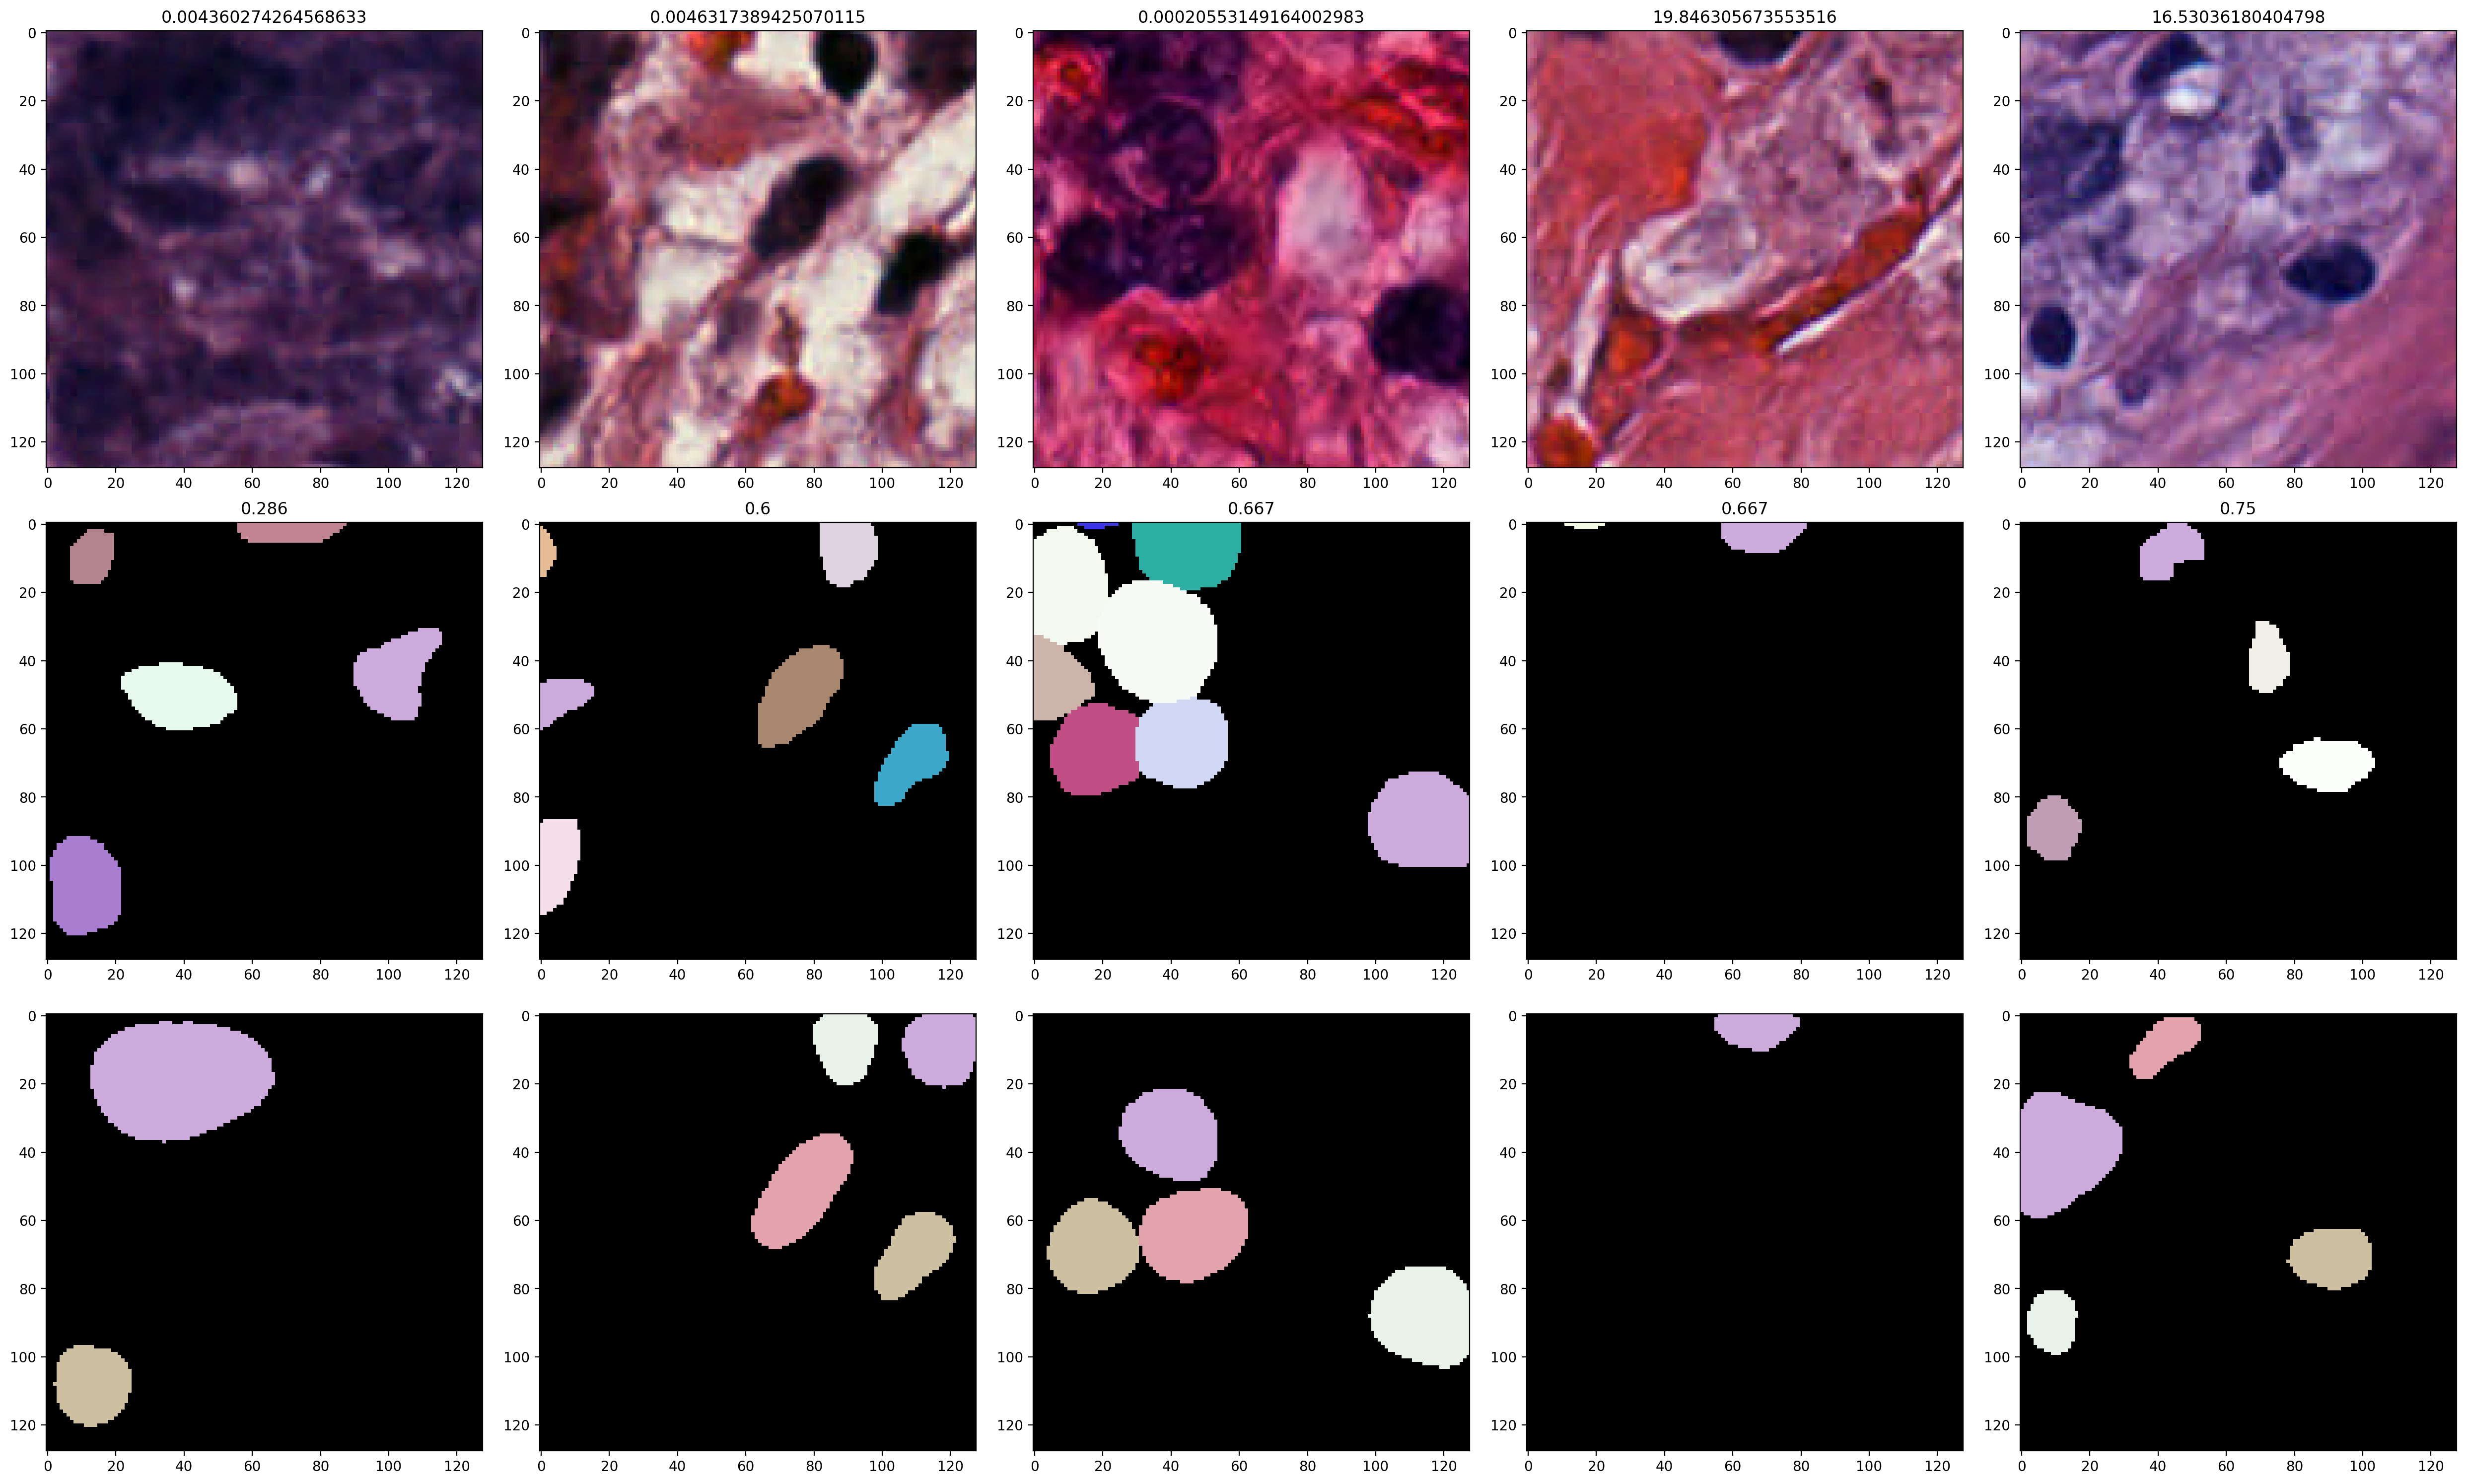

In [31]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 5, figsize=(25, 15))

ind = np.random.choice(len(sdm_image_list), 5, replace=False)

for i in range(5):
    y = ind[i]
    img = img_sdm_best[y]
    ann = Y_sdm_best[y]
    pred = Y_pred_sdm_best[y]
    f1 = getattr(stats_sdm_best[y], 'f1')


    ax[0, i].imshow(img)
    ax[0, i].set_title(prob[y])
    ax[1, i].imshow(ann, cmap=lbl_cmap)
    ax[1, i].set_title(f'{f1:.3}')
    ax[2, i].imshow(pred, cmap=lbl_cmap)

fig.tight_layout()

plt.show()

['/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_train_shuffle_model_s1.2_020000/samples/TCGA-NH-A8F7-01A-01-TS1_045.png',
 '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_train_shuffle_model_s1.2_020000/samples/TCGA-18-5592-01Z-00-DX1_012.png',
 '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_train_shuffle_model_s1.2_020000/samples/TCGA-G9-6356-01Z-00-DX1_049.png',
 '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_train_shuffle_model_s1.2_020000/samples/TCGA-B0-5698-01Z-00-DX1_026.png',
 '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_train_shuffle_model_s1.2_020000/samples/TCGA-G9-6336-01Z-00-DX1_045.png',
 '/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/output_

100%|██████████| 128/128 [00:01<00:00, 82.99it/s]


In [10]:
act_sdm.shape



(128, 2048)

In [ ]:
def plot_sample(stats):

    f1 = dict(
        F1 = [],
        exp = [],
        mean = []
    )

    dice = dict(
        Dice = [],
        exp = [],
        mean = []
    )

    x_vals = []

    f1_test = stats_sdm._asdict()['f1']

    for exp in exps:
        if exp not in metric or metric[exp]['sample'] is None: continue
        f1_test = [stat['f1'] for stat in metric[exp]['sample']['stats']]
        dice_test = metric[exp]['sample']['dice']

        f1['F1'].extend(f1_test)
        f1['exp'].extend([exp] * len(f1_test))
        f1['mean'].append(np.mean(f1_test))

        dice['Dice'].extend(dice_test)
        dice['exp'].extend([exp] * len(dice_test))
        dice['mean'].append(np.mean(dice_test))

        x_vals.append(exp)

    x_vals = range(len(x_vals))


## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predictions to disk.  
See [this notebook](../other2D/export_imagej_rois.ipynb) for more details on how to export ImageJ ROIs.

In [7]:
# save_tiff_imagej_compatible('example_image.tif', img, axes='YX')
# save_tiff_imagej_compatible('example_labels.tif', labels, axes='YX')
# export_imagej_rois('example_rois.zip', details['coord'])

# Example results

In [8]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

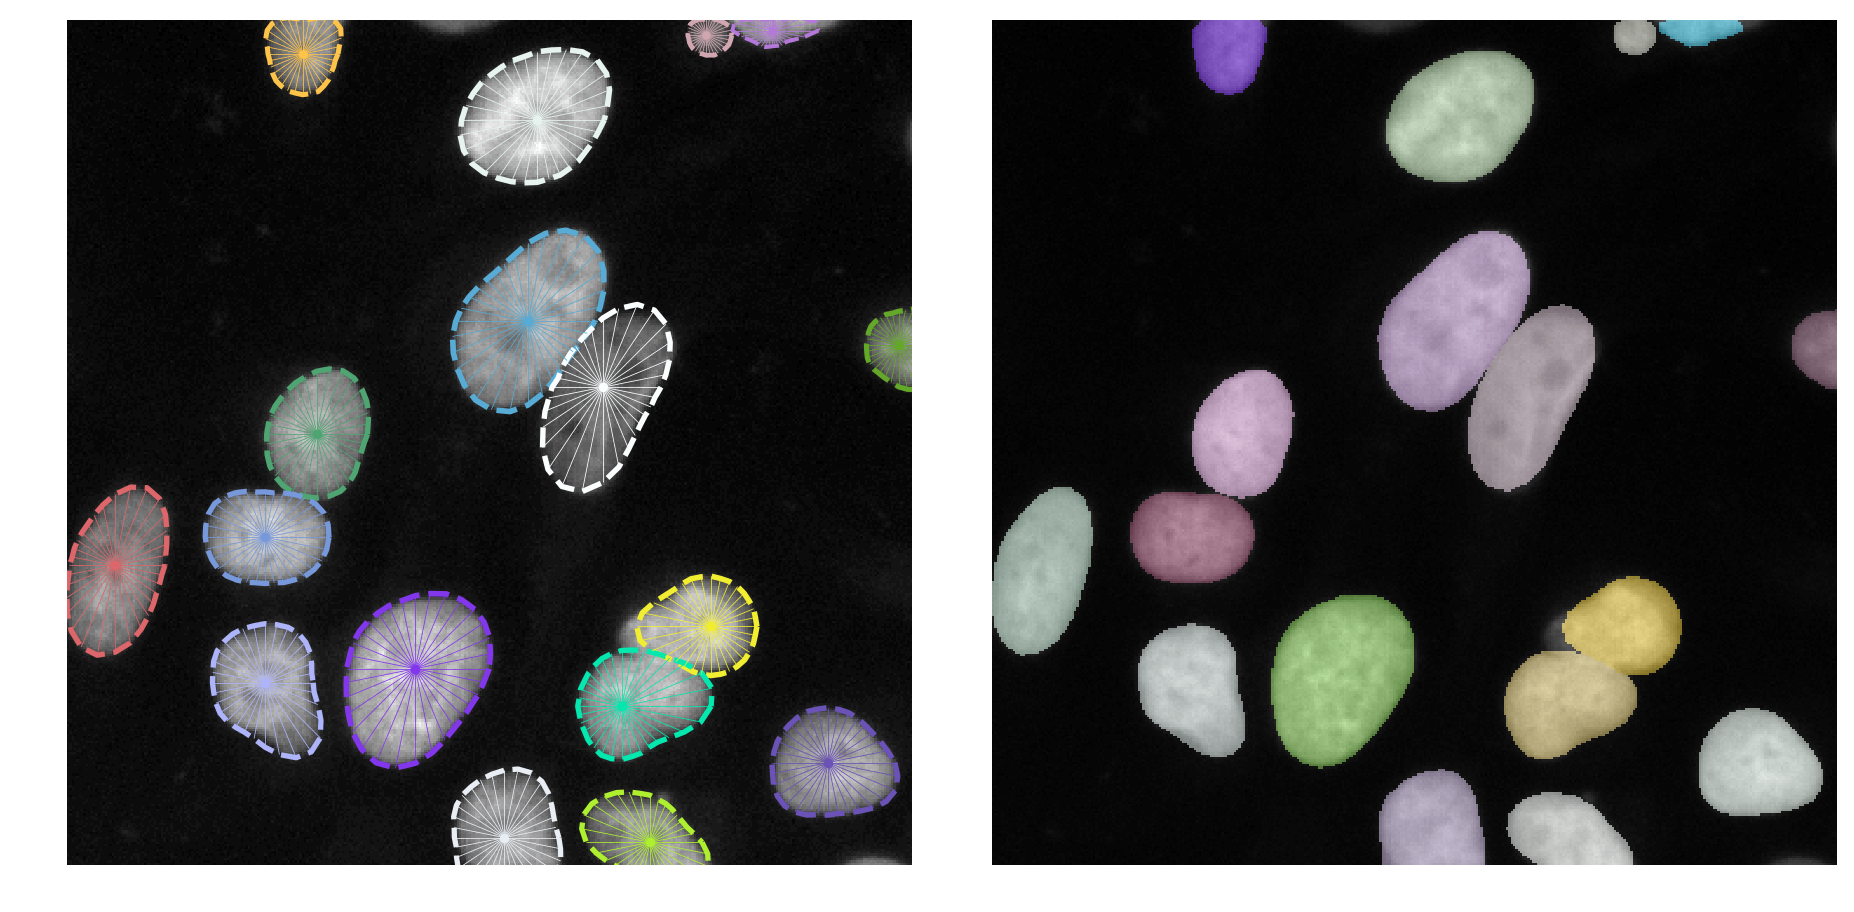

In [9]:
example(model, 42)

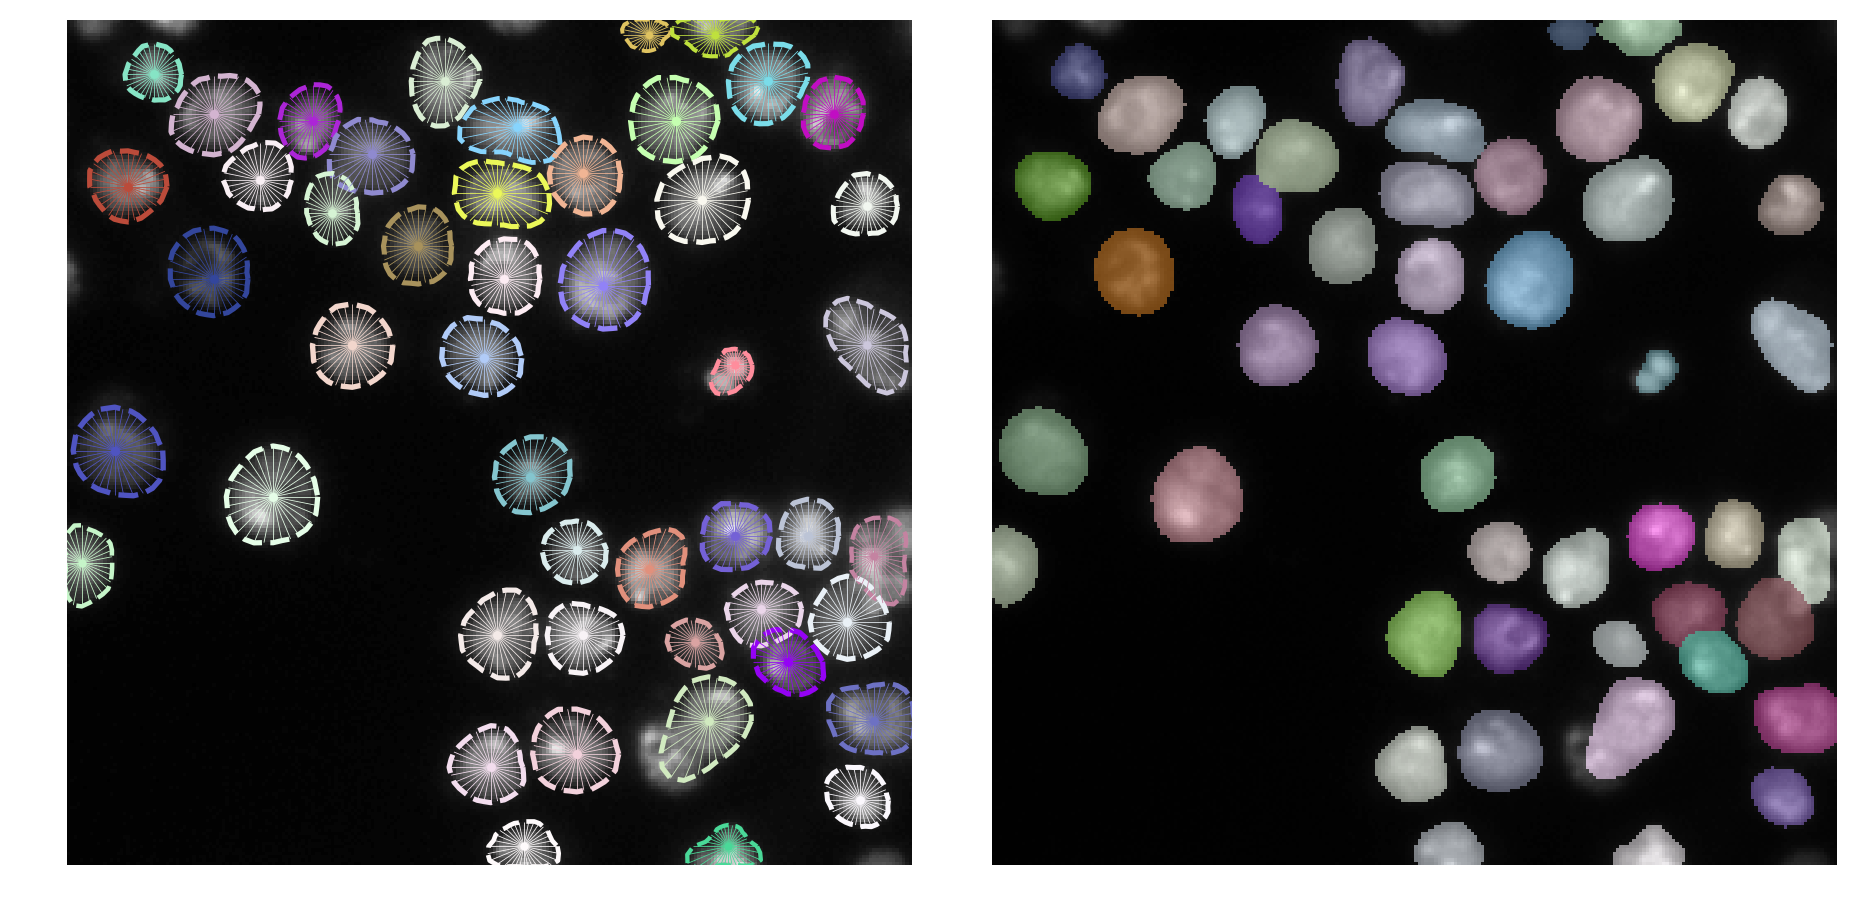

In [10]:
example(model, 1)

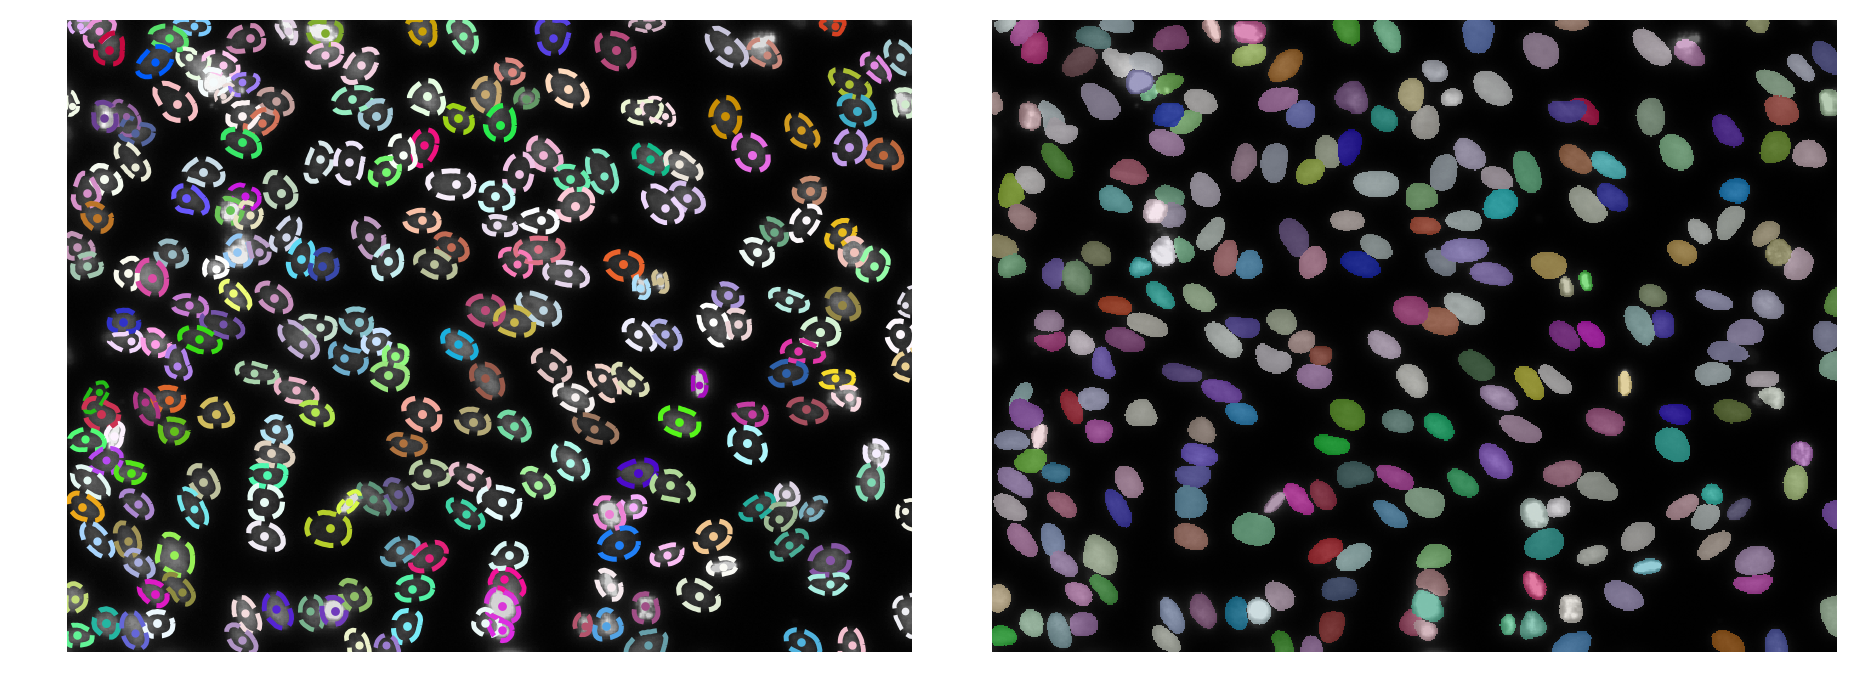

In [11]:
example(model, 15, False)

# Model from paper

In [12]:
model_paper = StarDist2D.from_pretrained('2D_paper_dsb2018')

Found model '2D_paper_dsb2018' for 'StarDist2D'.
Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.


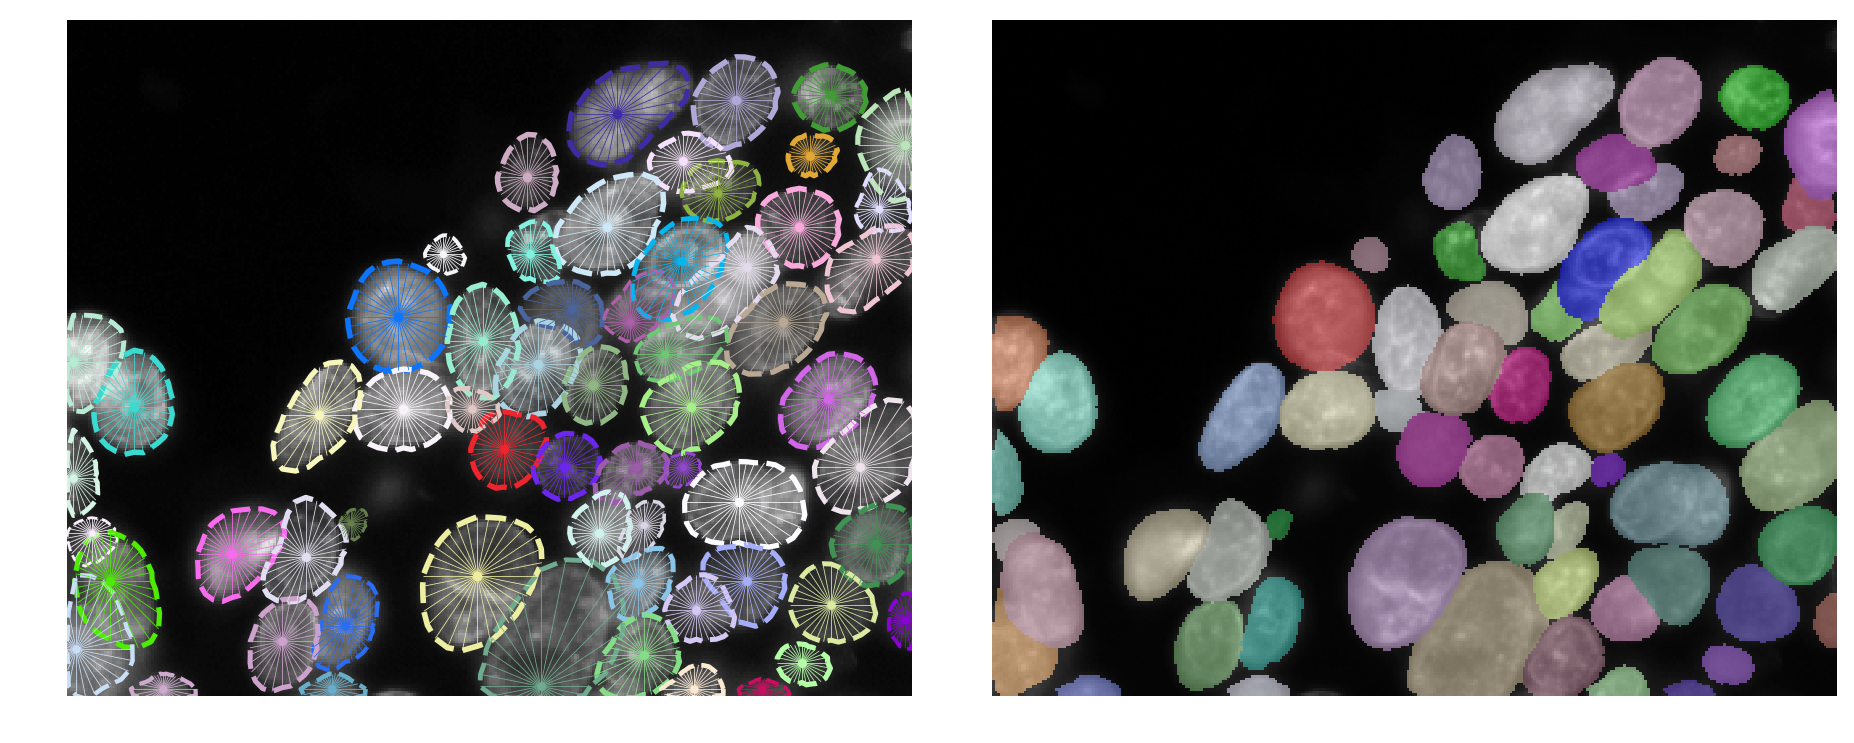

In [13]:
example(model_paper, 29)

# Versatile model

Try this model first if you have images that look similar to the training data in this example.

In [14]:
model_versatile = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


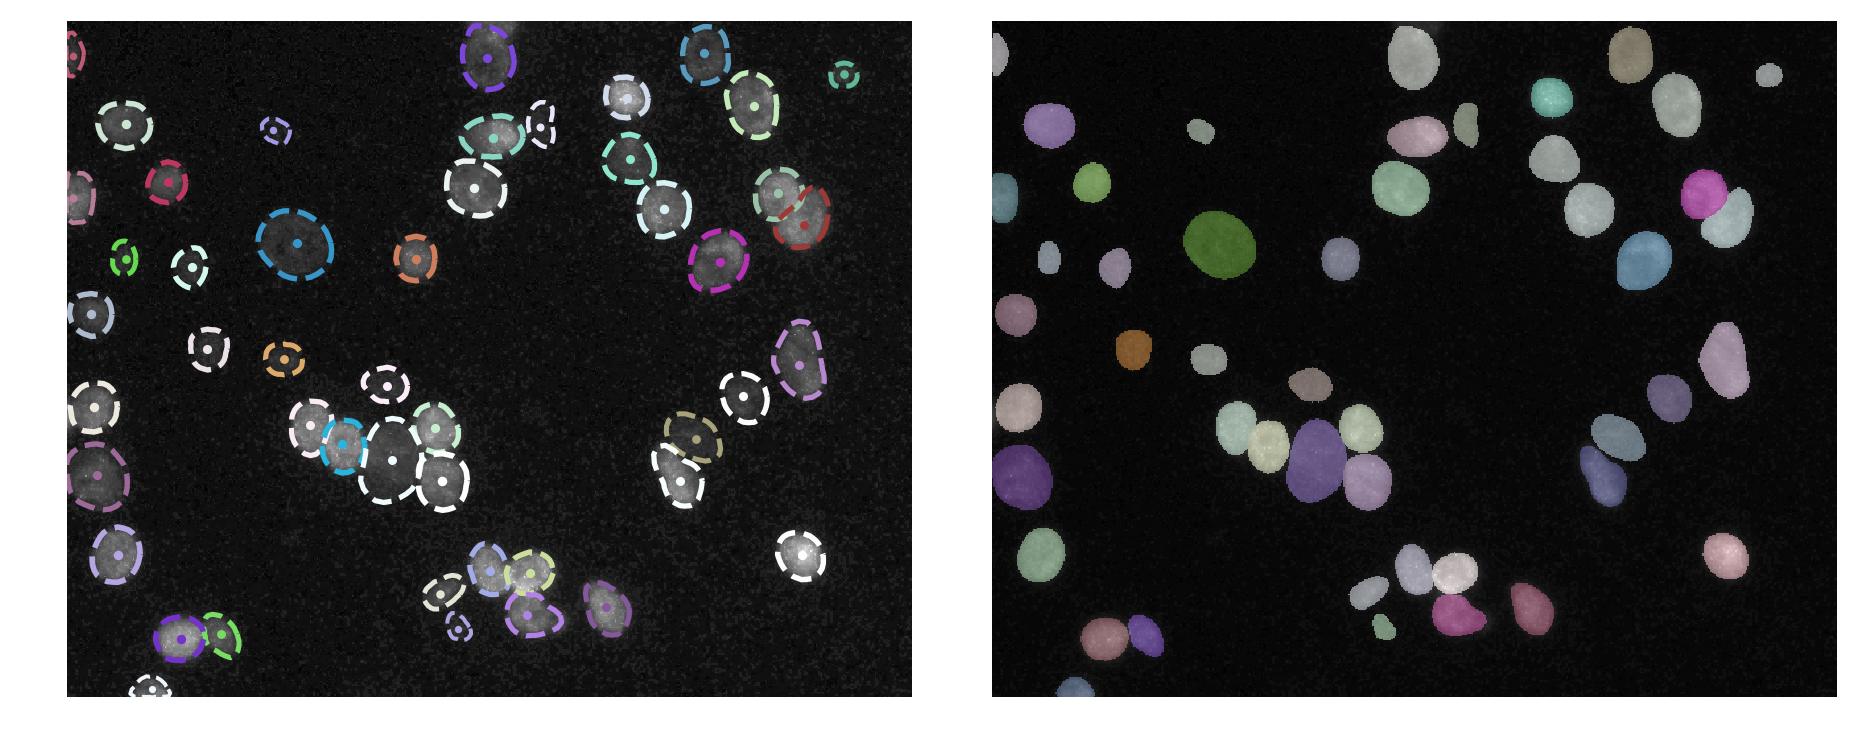

In [15]:
example(model_versatile, 30, False)

Show all available pretrained models:

In [16]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
